### Import libraries

In [528]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


### Data loading:

In [486]:
data = pd.read_csv('Demographic_Data.csv')
instore_df = pd.DataFrame(data = {'in-store': [0, 1], 'Method':['online', 'in-store']})
region_df = pd.DataFrame(data = {'region': [1, 2, 3, 4], 'Location':['North', 'South', 'East', 'West']})
data2 = pd.merge(data, instore_df)
data2 = pd.merge(data2, region_df)

### #Items vs Purchasing method

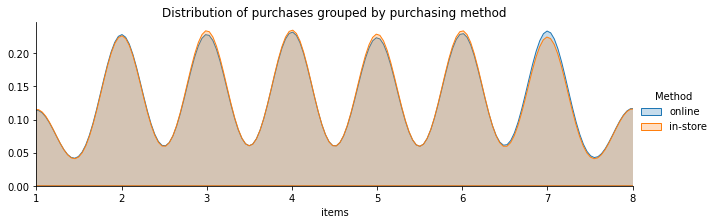

In [487]:
fig = sns.FacetGrid(data2, hue = 'Method', aspect = 3)
fig.map(sns.kdeplot, 'items', shade = True)
age_min = data2['items'].min()
age_max = data2['items'].max()
fig.set(xlim=(age_min, age_max))
fig.set(title='Distribution of purchases grouped by purchasing method')
fig.add_legend()
plt.show()

This is something I forgot to compare in the first task, I wanted to know if there was any difference between the amount of items people buy online versus the amount the would buy in-store. As we can see on the plot the distributions are nearly the same so the amount of items purchased appears to be not related with the purchasing method.

#### Summary of the task 1:

- The age is related to the purchasing method, we appreciate that the in-store method is most popular among 18 to 55 year old consumers while the oline method is less frequent but it spreads reaching higher ages. Althouhg that is the general behaviour if we look at each region independently we can see some differences, south --> only online shopping, north --> only in-store shopping, west --> same presence of both and east --> both methods present but in-store dominates over online.

- The net income produced by the e-commerce (\\$ 35902788.29) is higher than the income produced by the in-store sells (\\$ 30970785.28). Although, again, this depends on the region as we saw in the income table per region and purchasing method.

- Dividing the age into reasonable ranges we saw that the amount of items purchased has nothing to do with it since it shows the same distribution for all groups. We can also appreciate that the ages between 18 to 55 represent the main consumers in terms of amount of transaction and total amount spent.

- We also came to the conclusion that depending on the region the mean amount spent per transaction is different west --> \\$ 1284.05, east --> \\$ 917.97, norht --> \\$ 745.16 and south --> \\$ 252.11

- Looking at the relation between the amount of items purchased and the amount spent I couldn't see any clear linear regression of any type of relation between them. 


### Hypothesis:

    (1) The number of items doesn't show any clear relation with the other features so I suppose it will be negligible when training the models.
    (2) As we've seen that each region show different purchasing characteristics we should be able to classify a transaction into its appropiate region.
    (3) The age feature appeared to be related with the region (younger groups (18-55) tend to buy more and more often).    Therefore I assume it would be possible to desing a model that correctly classified the client into its age group.  
    (4) Creating a model that classifies the consumers into typical amount spend should be possible.

### Region Classification:

### Data Loading:
I am taking the samples from data and not from data2 since data2 (due to the merging process) is ordered and the train_test_split would take the sample from a biased dataset diminishing the accuracy

In [488]:
print('Complete dataset:')
display(data.head(3))

# Features matrix:
X = data.iloc[:, 0:4]
print('\nFeatures matrix: ', X.shape)
display(X.head(3))

# Response vector:
y = data['region']
print('\nResponse vector: ', y.shape)
display(y.head(3))

Complete dataset:


,in-store,age,items,amount,region
0,0,37,4,281.03,2
1,0,35,2,219.51,2
2,1,45,3,1525.70,4



Features matrix:  (80000, 4)


,in-store,age,items,amount
0,0,37,4,281.03
1,0,35,2,219.51
2,1,45,3,1525.70



Response vector:  (80000,)


0    2
1    2
2    4
Name: region, dtype: int64

### Decision Tree
#### Tuning hyperparameters:
    (i) Train_test_split:

In [578]:
# First we split the data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)

# Loop to decide which are the best paramaters:
scores = []
depth = range(2, 20)

for i in depth:
    dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = i, random_state = 42)
    dtc.fit(X_train, y_train)
    scores.append(accuracy_score(dtc.predict(X_test), y_test))

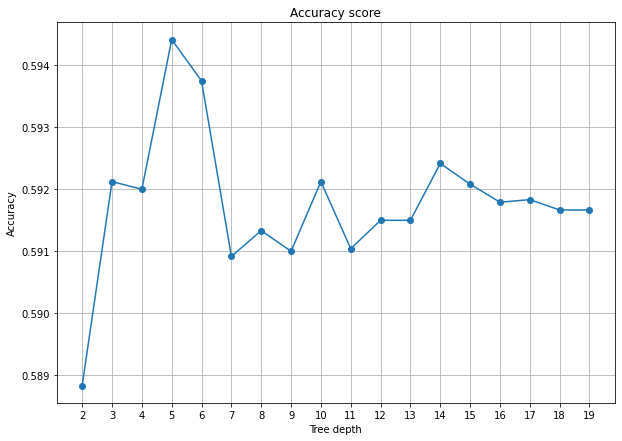

In [579]:
plt.figure(figsize = (10, 7))
plt.plot(depth, scores, marker = 'o')
plt.xticks(depth)
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.title('Accuracy score')
plt.grid()

In [580]:
# classification report:
print(classification_report(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [24000, 3]

As we can see the best accuracy performance (for a reasonable complexity to avoid overfitting) is given by the decision tree with max_depth = 4 so this will be the value I use. The splitting criterion 'Entropy' was chosen as it is usually the best performer. 

    (ii) Cross validation:

In [120]:
# Loop to decide which are the best paramaters:
cross_val_scores = []

for i in depth:
    dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = i, random_state = 42)
    cross_val_scores.append(cross_val_score(dtc, X, y, cv = 5).mean())

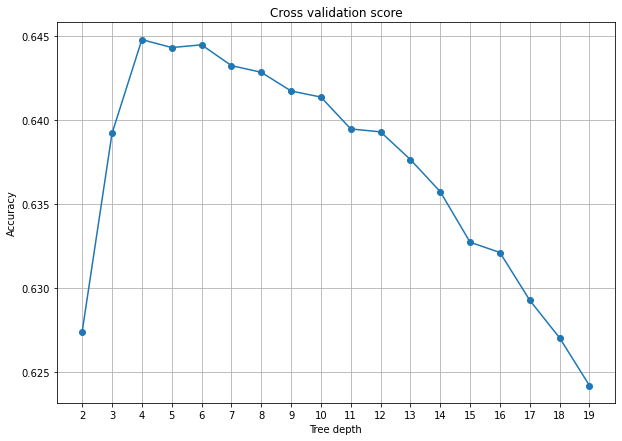

In [121]:
plt.figure(figsize = (10, 7))
plt.plot(depth, cross_val_scores, marker = 'o')
plt.xticks(depth)
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.title('Cross validation score')
plt.grid()

In [130]:
print('Best performer model cross validation score:\n',
      round(cross_val_score(DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state = 42),
                      X, y, cv = 5).mean(), 4))

Best performer model cross validation score:
 0.6448


Again, we can appreciate that the best performance for the least complexity is given by max_depth = 4. However, here we see that max_depth = 5 and 6 performed nearly as well as 4 so, in case we need our model more flexible to be able to emulate the feature relation those would be a good choice too.

    (iii) GridSearchCv:

In [491]:
%%time
# Uncomment one by one the parameters variable and run the cell each time. (max time of 30 seconds)

#parameters = {'criterion':('gini', 'entropy'), 'max_depth':range(2,15)}

# After several tries --> criterion and max_depth don't change so I leave them fixed to save time

#parameters = {'criterion': ['entropy'], 'max_depth':[4], 'min_samples_split':  range(2, 50)}#--> min split=2(default value)
parameters = {'criterion': ['entropy'], 'max_depth':[4], 
              'min_samples_split':  range(2,11), # --> best min split = 2 (default value)
              'min_samples_leaf': range(1,10)} # --> best min leaf = 7 

models_grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), parameters)
models_grid.fit(X, y)
print('Best tuning of the hyperparameters:\n\n', models_grid.best_params_,'\n')


Best tuning of the hyperparameters:

 {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2} 

Wall time: 30.1 s


In [153]:
print('Best performer model cross validation score with more hyperparameters:\n',
      round(cross_val_score(DecisionTreeClassifier(criterion = 'entropy', max_depth = 4,
                                             min_samples_leaf = 7,random_state = 42),
                      X, y, cv = 5).mean(), 4))

Best performer model cross validation score with more hyperparameters:
 0.6448


Using GridSearchCV we prove that 'Entropy' is the best criterion and that max_depth = 4, after trying some other hyper parameters most of them were best tuned at its default value so I don't change it, only min_samples_leaf = 7 performs better. It is actually possible to achieve higher scores with another tunings e.g. min_samples_leaf = 117 and min_samples_split = 147 but I am afraid that would increase the variance of the model since that tuning would focused too much on the available dataset.

In [176]:
dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, min_samples_leaf = 7,random_state = 42)
dtc.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=7,
                       random_state=42)

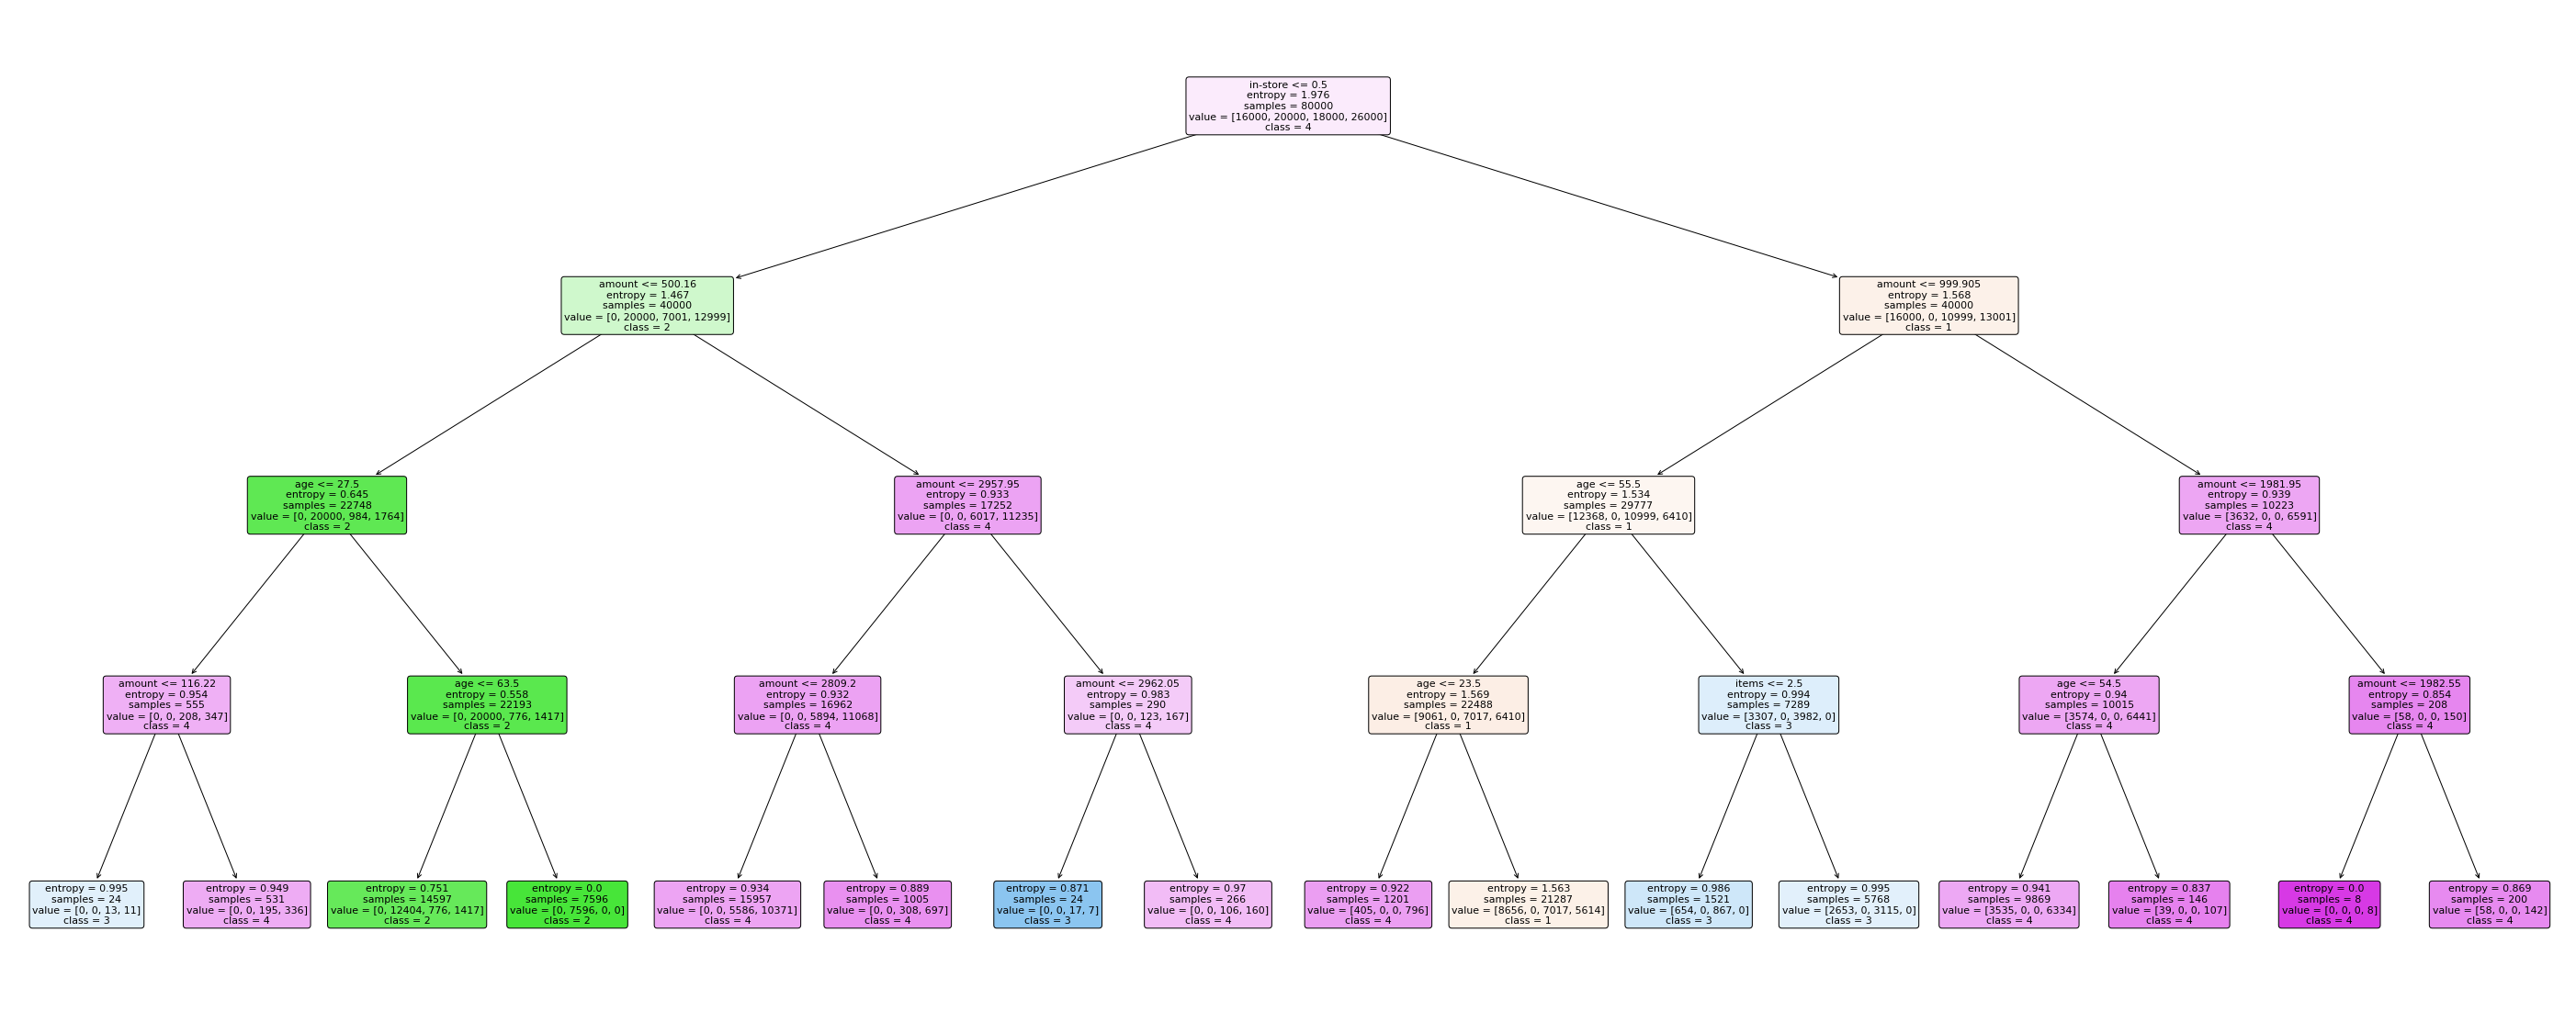

In [166]:
fig = plt.figure(figsize=(50,20))

plot_tree(dtc, feature_names = X.columns, class_names = ['1', '2', '3', '4'], rounded = True, filled = True, fontsize = 11)
fig.savefig('DecisionTree.svg')
plt.show()

In [183]:
display(X.head(3))
print('Features importances:')
aux = 0
for i in X.columns.values:
    print(i, ':    ', round(dtc.feature_importances_[aux], 5))
    aux += 1

,in-store,age,items,amount
0,0,37,4,281.03
1,0,35,2,219.51
2,1,45,3,1525.70


Features importances:
in-store :     0.46227
age :     0.09151
items :     4e-05
amount :     0.44618


The tree visualization shows the final decision tree train with the whole dataset and ready for making new predictions. I recommend to download the image to see the details I am going to discuss:

- We managed to create a predictive model (decision tree) able to classify a transaction into its region with and accuracy of 0.65.
- The first decision is made over the purchasing method because is the feature that reduce the entropy the most. We can also see how most of the decisions are taken depending on age or amount but only one is made taken into account the number of items (actually this only happens for this specific tuning of the hyperparameters for the rest of them it doesn't even appear), this suggest that it could be removed from the dataset without affecting the results as I predicted on task 1.

#### Removal of items feature:
By removing the negligible feature the cross validation score remain nearly the same (a bit better).

In [184]:
dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, min_samples_leaf = 7,random_state = 42)
round(cross_val_score(dtc, X.drop('items', axis = 1), y, cv = 5).mean(),4)

0.6449

## Age classification:
### Cut: 
This built-in function cuts the feature into n groups with the same width.

In [470]:
# Definition of some functions I will use more than once.

def cut_groups(groups, response, kind = 'cut'):
    
    '''
        Function that cuts the data into groups and returns a tuple: features matrix, response vector
        groups = number of groups
        response = independent variable
        kind = type of cut mode {'cut', 'qcut'}
    '''
    
    data = pd.read_csv('Demographic_Data.csv')
    if kind == 'qcut':
        cut_series, cut_intervals = pd.qcut(data[response], groups, retbins = True, labels = range(1, groups + 1)) 
    else:
        cut_series, cut_intervals = pd.cut(data[response], groups, retbins = True, labels = range(1, groups + 1)) 
    
    # Assing the discretized data into the dataset
    data[response] = cut_series

    # Drop the feature that is not related to the independent variable
    data.drop('items', axis = 1, inplace = True)
    return data.drop(response, axis = 1), data[response], cut_intervals

def cut_performance(response, kind = 'cut', eps = 6):
    '''
        Function that discretize the response vector in n groups, uses cross-validation to test which is the best values
        for max_depth and returns a tuple with all those values
        response = independent variable
        eps = max number of groups
    '''
    score = []
    max_depth = []
    cut_intervals = [] 

    n = range(1, eps + 1) # In case more groups are needed just change the end extreme of the range
    for i in n:
        X, y, cuts = cut_groups(i, response, kind)
    
        cut_intervals.append(cuts)
    
        # Tuning of the max_depth hyperparameter
        depths = range(2, 10)
        sub_scores = []
        for j in depths:
            dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = j, random_state = 42)
            sub_scores.append(cross_val_score(dtc, X, y, cv = 5).mean())
        # Results for each amount of groups   
        ind = sub_scores.index(max(sub_scores)) + 1
        max_depth.append(depths[ind])
        score.append(max(sub_scores)) 
    return score, max_depth, cut_intervals


In [395]:
# This cell does the same as the one bellow but using train_test_split and max_depth = 4 always. I commented it because the
# other one uses cross validation (reducing the overall bias) and it also computes the performance for different max_depths
# (the max_depths belong to an interval of reasonable candidates to avoid overfitting) finally choosing the best tuning
# for the max_depth for each group division and the computation time is not too much.

'''score = []
n = range(1, 7)
for i in n:
    X, y = cut_age(i)
    # Train test function is faster
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)
    
    dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state = 42)
    dtc.fit(X_train, y_train)
    score.append(accuracy_score(y_test, dtc.predict(X_test)))'''

In [471]:
%%time
# ESTIMATED TIME OF 20 SECONDS for 6 age groups
score, max_depth, cut_intervals = cut_performance('age')

Wall time: 20.3 s


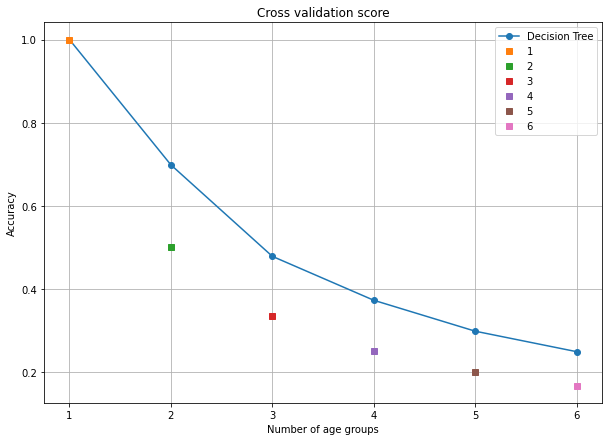

In [472]:
plt.figure(figsize = (10, 7))
plt.plot(n, score, marker = 'o', label = 'Decision Tree')
plt.xticks(n)
plt.xlabel('Number of age groups')
plt.ylabel('Accuracy')
plt.title('Cross validation score')
plt.grid()
for i in n:
    #plt.plot([1, len(n)], [1/i, 1/i], '-', label = i)
    plt.plot(i, 1/i, 's', label = i)
plt.legend()
plt.show()

In [473]:
results = pd.DataFrame(data = {'Number of Age Groups' : n,
                     'max_depth' : max_depth, 
                     'cross validation' : score})
# Rounding of the scores
results['cross validation'] = results['cross validation'].apply(lambda x: round(x, 3))
results['Dummy prediction'] = [round(1/i, 3) for i in n]
display(results)

,Number of Age Groups,max_depth,cross validation,Dummy prediction
0,1,3,1.000,1.000
1,2,5,0.698,0.500
2,3,6,0.478,0.333
3,4,5,0.372,0.250
4,5,5,0.297,0.200
5,6,5,0.248,0.167


Here we developed an algorithm that divides the age into n groups (same amount of samples on each one) and computes the accuracy of predicting the group age of the customer that made a specific transaction. It also compares its accuracy with the dummy model of classifiying at random among the available age groups. As we can see in the plot our model performs better than the random one, and on the dataframe displayed bellow the pot we can see the actual expected accuracy of each case.

We can obtain where the cuts made for each group as follows:

In [445]:
def v_round(x):
    return '%.2f' % x

v_round = np.vectorize(v_round) # I need to vectorized the function to apply it to each element of a vector

aux = 0
for i in cut_intervals:
    print(n[aux], 'age group divisions at ages: ', v_round(i), '\n')
    aux += 1

1 age group divisions at ages:  ['17.93' '85.00'] 

2 age group divisions at ages:  ['17.93' '51.50' '85.00'] 

3 age group divisions at ages:  ['17.93' '40.33' '62.67' '85.00'] 

4 age group divisions at ages:  ['17.93' '34.75' '51.50' '68.25' '85.00'] 

5 age group divisions at ages:  ['17.93' '31.40' '44.80' '58.20' '71.60' '85.00'] 

6 age group divisions at ages:  ['17.93' '29.17' '40.33' '51.50' '62.67' '73.83' '85.00'] 



### Qcut: 
This built-in function cuts the feature into the n quantiles of the dataset so all bins have same amount of samples but different widths

In [453]:
%%time
# ESTIMATED TIME OF 20 SECONDS for 6 age groups

q_score, q_max_depth, q_cut_intervals = cut_performance('age', kind = 'qcut')

Wall time: 21 s


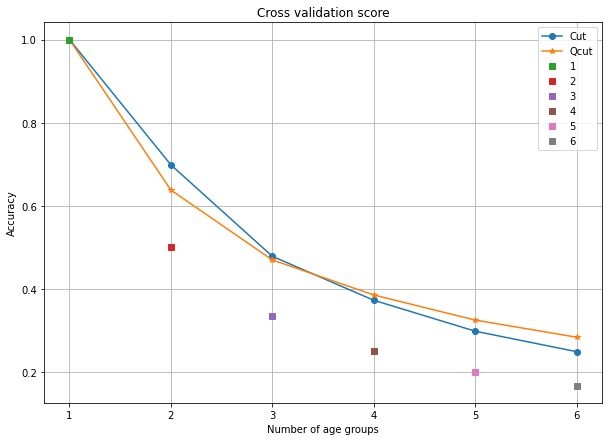

In [454]:
plt.figure(figsize = (10, 7))
plt.plot(n, score, marker = 'o', label = 'Cut')
plt.plot(n, q_score, marker = '*', label = 'Qcut')
plt.xticks(n)
plt.xlabel('Number of age groups')
plt.ylabel('Accuracy')
plt.title('Cross validation score')
plt.grid()
for i in n:
    #plt.plot([1, len(n)], [1/i, 1/i], '-', label = i)
    plt.plot(i, 1/i, 's', label = i)
plt.legend()
plt.show()

In [455]:
# Rounding of the scores
results['cross validation quantiles'] = q_score
results['cross validation quantiles'] = results['cross validation quantiles'].apply(lambda x: round(x, 3))

display(results)

,Number of Age Groups,max_depth,cross validation,Dummy prediction,cross validation quantiles
0,1,3,1.000,1.000,1.000
1,2,5,0.698,0.500,0.637
2,3,6,0.478,0.333,0.469
3,4,5,0.372,0.250,0.385
4,5,5,0.297,0.200,0.324
5,6,5,0.248,0.167,0.283


Following the same fashion as we did with pd.cut() build in method now we have done it with pd.qcut() method, or what is the same, now the cuts have been done taking into account that each bin must contain the same amount of samples (the bins have different widths now). From the results, we can conclude that this model also performs better than predicting the values randomly. However we see something interesting, when we increase the number of age groups required qcut shows a better performance, so depending on the amount of groups needed by the company we should use the 'cut' model or the 'qcut'.

We can obtain where the qcuts made for each group as follows:

In [394]:
aux = 0
for i in q_cut_intervals:
    print(n[aux], 'age group divisions at ages: ', i, '\n')
    aux += 1

1 age group divisions at ages:  [18. 85.] 

2 age group divisions at ages:  [18. 45. 85.] 

3 age group divisions at ages:  [18. 37. 52. 85.] 

4 age group divisions at ages:  [18. 33. 45. 56. 85.] 

5 age group divisions at ages:  [18. 31. 40. 49. 60. 85.] 

6 age group divisions at ages:  [18. 29. 37. 45. 52. 62. 85.] 



## Amount classification:
### Cut: 

In [463]:
%%time
# ESTIMATED TIME OF 5 SECONDS for 6 age groups

score, max_depth, cut_intervals = cut_performance('amount')

Wall time: 5.8 s


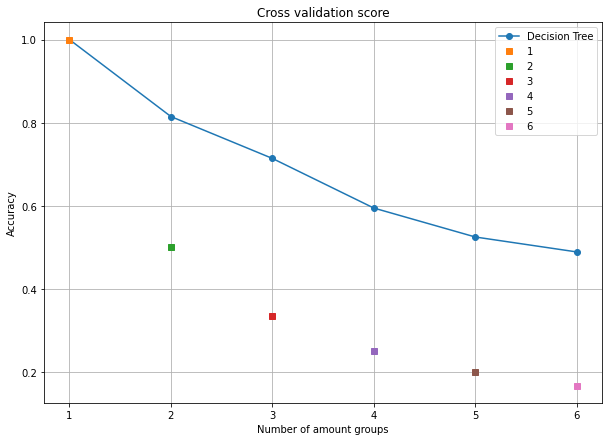

In [464]:
plt.figure(figsize = (10, 7))
plt.plot(n, score, marker = 'o', label = 'Decision Tree')
plt.xticks(n)
plt.xlabel('Number of amount groups')
plt.ylabel('Accuracy')
plt.title('Cross validation score')
plt.grid()
for i in n:
    #plt.plot([1, len(n)], [1/i, 1/i], '-', label = i)
    plt.plot(i, 1/i, 's', label = i)
plt.legend()
plt.show()

In [465]:
results_amount = pd.DataFrame(data = {'Number of Amount Groups' : n,
                     'max_depth' : max_depth, 
                     'cross validation' : score})
# Rounding of the scores
results_amount['cross validation'] = results_amount['cross validation'].apply(lambda x: round(x, 3))
results_amount['Dummy prediction'] = [round(1/i, 3) for i in n]
display(results_amount)

,Number of Amount Groups,max_depth,cross validation,Dummy prediction
0,1,3,1.000,1.000
1,2,3,0.815,0.500
2,3,6,0.714,0.333
3,4,4,0.594,0.250
4,5,6,0.524,0.200
5,6,3,0.488,0.167


If we apply the same analysis but now we discretize the amount with pd.cut() we get a very interesting model because the cross validation score for a reasonable amount of groups (1 to 5) is over the 50% which is well over the random model and it can have useful applications, for example when studying which offers may result in the larger amount spent.

In [479]:
def v_round(x):
    return '$' + '%.2f' % x

v_round = np.vectorize(v_round) # I need to vectorized the function to apply it to each element of a vector

aux = 0
for i in cut_intervals:
    print(n[aux], 'Amount group divisions at amounts: ', v_round(i), '\n')
    aux += 1

1 Amount group divisions at amounts:  $2.01 

2 Amount group divisions at amounts:  $753.75 

3 Amount group divisions at amounts:  $1502.50 

4 Amount group divisions at amounts:  $2251.25 

5 Amount group divisions at amounts:  $3000.00 



### Qcut: 

In [466]:
%%time
# ESTIMATED TIME OF 7 SECONDS for 6 age groups

q_score, q_max_depth, q_cut_intervals = cut_performance('amount', kind = 'qcut')

Wall time: 6.75 s


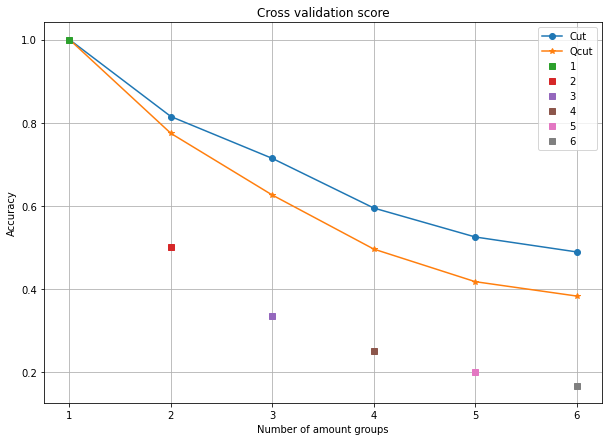

In [467]:
plt.figure(figsize = (10, 7))
plt.plot(n, score, marker = 'o', label = 'Cut')
plt.plot(n, q_score, marker = '*', label = 'Qcut')
plt.xticks(n)
plt.xlabel('Number of amount groups')
plt.ylabel('Accuracy')
plt.title('Cross validation score')
plt.grid()
for i in n:
    #plt.plot([1, len(n)], [1/i, 1/i], '-', label = i)
    plt.plot(i, 1/i, 's', label = i)
plt.legend()
plt.show()

In [468]:
# Rounding of the scores
results_amount['cross validation quantiles'] = q_score
results_amount['cross validation quantiles'] = results_amount['cross validation quantiles'].apply(lambda x: round(x, 3))

display(results_amount)

,Number of Amount Groups,max_depth,cross validation,Dummy prediction,cross validation quantiles
0,1,3,1.000,1.000,1.000
1,2,3,0.815,0.500,0.774
2,3,6,0.714,0.333,0.625
3,4,4,0.594,0.250,0.495
4,5,6,0.524,0.200,0.417
5,6,3,0.488,0.167,0.382


Unlike what happened with the age groups classification, pd.qcut() method does not contribute to a better performance at any case so the model is discarded.

### Other classification algorithms:
Now I will use two other algorithms from sklearn (randomforest and gradientboosting) to see if I can improve the performance of the model that predicts the amount (discretize in 4 groups) as from my point of view is one of the most useful models.

In [502]:
X, y, cut_intervals = cut_groups(4, 'amount')

# Features matrix:
print('\nFeatures matrix: ', X.shape)
display(X.head(3))

# Response vector:
print('\nResponse vector: ', y.shape)
display(y.head(3))

print(4, 'Amount group divisions at amounts: ', v_round(cut_intervals), '\n')


Features matrix:  (80000, 3)


,in-store,age,region
0,0,37,2
1,0,35,2
2,1,45,4



Response vector:  (80000,)


0    1
1    1
2    3
Name: amount, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

4 Amount group divisions at amounts:  ['$2.01' '$753.75' '$1502.50' '$2251.25' '$3000.00'] 



In [497]:
%%time
# ESTIMATED TIME OF 1 min

# Random forest hyperparameters tuning
rdf_score = []
depth = range(1,10)

for i in depth:
    rdf = RandomForestClassifier(max_depth = i, random_state = 42)
    rdf_score.append(cross_val_score(rdf, X, y).mean())

Wall time: 51.9 s


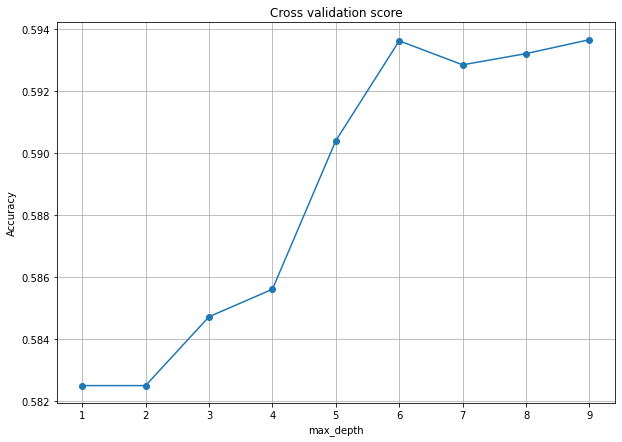

In [498]:
plt.figure(figsize = (10, 7))
plt.plot(depth, rdf_score, marker = 'o')
plt.xticks(depth)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Cross validation score')
plt.grid()

In this case the best accuracy for the least complexity is given by max_depth = 6, since my computer is not that powerful I cannot use GridSearchCV to tune it better with other parameters like n_estimators.

In [535]:
algos = []
# Decision tree classifier:
dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, min_samples_leaf = 7, random_state = 42)
algos.append(('Decision tree classifier', dtc))

# Random forest:
rdf = RandomForestClassifier(max_depth = 6, random_state = 42)
algos.append(('Random forest', rdf))

# Gradient boosting:
# I cannot tune this parameters on my computers it takes 5plus min
gbc = GradientBoostingClassifier(random_state = 42)
algos.append(('Gradient boosting', gbc))


In [525]:
%%time
# ESTIMATED TIME OF 1min

for name, model in algos:
    %time result = round(cross_val_score(model, X, y, cv = 5).mean(), 4)
    print(name + ':', '\t', result)

Wall time: 146 ms
Decision tree classifier: 	 0.5932
Wall time: 6.27 s
Random forest: 	 0.5936
Wall time: 56.4 s
Gradient boosting: 	 0.5932
Wall time: 1min 2s


In this case all of them show more less the same accuracy, but we can clearly see that the computation cost and therefore the computation time is increasing depending on the algo complexity. Although the have the same accuracy, because of how they are constructed it would better to use random forest or gradient boosting to reduce the variance of the bias.

### Further comparisson of the models:

In [536]:
# First we split the data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

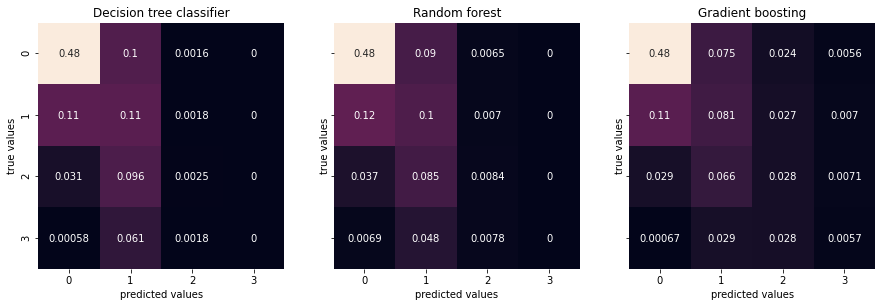

Wall time: 11.1 s


In [575]:
%%time
# ESTIMATED TIME OF 15 sec

fig, axes = plt.subplots(1, 3, figsize = (15,10), sharey = True)

aux = 0
y_pred = []
for name, model in algos:
    y_pred.append(model.fit(X_train, y_train).predict(X_test))
    mat = confusion_matrix(y_test, 
                           y_pred[aux], 
                           normalize = 'all')
    
    sns.heatmap(mat, square=True, annot=True, cbar=False, ax = axes[aux])
    axes[aux].set_xlabel('predicted values')
    axes[aux].set_ylabel('true values')
    axes[aux].set(title = name)
    aux += 1 
    
    
plt.show()

In this plot we can see where the mis-labeled points tend to be. And we can clearly see how the Decision tree model and Random forest fail to classify the forth amount group correctly. Therefore, although they show better accuracy their recall and precision is worst than for the Gradient boosting as seen bellow. Hence, with the GradientBoosting classifier we cannot improve the overall accuracy but we indeed can improve the overall performance thanks to a better precision and better recall of the model.

In [576]:
aux = 0
for i in y_pred:
    print('\n', algos[aux][0], '\n')
    print(classification_report(i, y_test, zero_division = 0))
    aux += 1


 Decision tree classifier 

              precision    recall  f1-score   support

           1       0.82      0.77      0.79     14934
           2       0.49      0.30      0.37      8882
           3       0.02      0.33      0.04       184
           4       0.00      0.00      0.00         0

    accuracy                           0.59     24000
   macro avg       0.33      0.35      0.30     24000
weighted avg       0.69      0.59      0.63     24000


 Random forest 

              precision    recall  f1-score   support

           1       0.83      0.75      0.79     15533
           2       0.44      0.31      0.36      7754
           3       0.06      0.28      0.11       713
           4       0.00      0.00      0.00         0

    accuracy                           0.59     24000
   macro avg       0.33      0.34      0.31     24000
weighted avg       0.68      0.59      0.63     24000


 Gradient boosting 

              precision    recall  f1-score   support

      